In [3]:
import os
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt
from textblob import Word
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
import pickle 
from sklearn.pipeline import Pipeline

In [2]:
path = '/media/sreelal/CA24611524610633/FORSK Internship/Clothing_Shoes_and_Jewelry.json.gz'

In [3]:
print(os.path.isfile(path))

True


In [ ]:
df_reader = pd.read_json(path, lines=True, chunksize=1000000, compression='gzip')
counter = 1
for chunk in df_reader:
    new_df = pd.DataFrame(chunk[['overall','reviewText','summary']])
    new_df1 = new_df[new_df['overall'] == 5].sample(4000)
    new_df2 = new_df[new_df['overall'] == 4].sample(4000)
    new_df3 = new_df[new_df['overall'] == 3].sample(8000)
    new_df4 = new_df[new_df['overall'] == 2].sample(4000)
    new_df5 = new_df[new_df['overall'] == 1].sample(4000)
    
    new_df6 = pd.concat([new_df1,new_df2,new_df3,new_df4,new_df5], axis = 0, ignore_index = True)
    
    new_df6.to_csv(str(counter)+".csv", index = False)
    
    new_df = None
    counter = counter + 1

In [ ]:
from glob import glob
filenames = glob('*.csv')
dataframes = [pd.read_csv(f) for f in filenames]
frame = pd.concat(dataframes, axis = 0, ignore_index = True)
frame.to_csv('/media/sreelal/CA24611524610633/FORSK Internship/balanced_review.csv', index = False)

In [1]:
import pandas as pd

df = pd.read_csv('/media/sreelal/CA24611524610633/FORSK Internship/balanced_review.csv')

In [6]:
df.head()

,overall,reviewText,summary
0,5,Purchased for my daughter and the fit is great...,Five Stars
1,5,"Love these shoes! Nice color, very comfortable.",Five Stars
2,5,Love these shoes. I can wear them all day long!,Great shoes
3,5,Good quality jeans for great price.,Five Stars
4,5,Got what I ordered and wanted. Thanks!,Five Stars


In [2]:
df.shape

(792000, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792000 entries, 0 to 791999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     792000 non-null  int64 
 1   reviewText  791385 non-null  object
 2   summary     791730 non-null  object
dtypes: int64(1), object(2)
memory usage: 18.1+ MB


In [5]:
df.describe(include='all')

,overall,reviewText,summary
count,792000.000000,791385,791730
unique,NaN,738645,419828
top,NaN,Good,Three Stars
freq,NaN,1021,71171
mean,3.000000,NaN,NaN
std,1.290995,NaN,NaN
min,1.000000,NaN,NaN
25%,2.000000,NaN,NaN
50%,3.000000,NaN,NaN
75%,4.000000,NaN,NaN


In [7]:
#dropping summary column
df=df.drop('summary',1)

In [8]:
df.columns=['overall','review']

In [9]:
df.isna().sum()

overall      0
review     615
dtype: int64

In [10]:
df.dropna(subset=['review'],inplace=True)

In [11]:
df.isna().sum()

overall    0
review     0
dtype: int64

In [12]:
df.head()

,overall,review
0,5,Purchased for my daughter and the fit is great...
1,5,"Love these shoes! Nice color, very comfortable."
2,5,Love these shoes. I can wear them all day long!
3,5,Good quality jeans for great price.
4,5,Got what I ordered and wanted. Thanks!


In [13]:
df['overall'].value_counts()

3    263876
2    131961
1    131904
4    131871
5    131773
Name: overall, dtype: int64

Text(0, 0.5, 'Label')

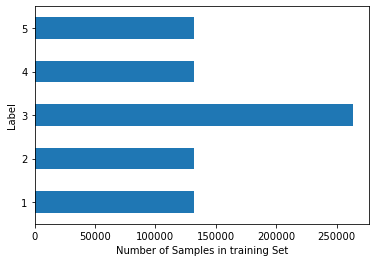

In [14]:
ax = df['overall'].value_counts(sort=False).plot(kind='barh')
ax.set_xlabel('Number of Samples in training Set')
ax.set_ylabel('Label')

In [15]:
# Adding new column rating, with review ratings > 3 are labelled 1 (positive review) and review ratings < 3 are labelled 0 (negative review)  
df['rating']=np.where(df['overall']>=3,1,0)
df

,overall,review,rating
0,5,Purchased for my daughter and the fit is great...,1
1,5,"Love these shoes! Nice color, very comfortable.",1
2,5,Love these shoes. I can wear them all day long!,1
3,5,Good quality jeans for great price.,1
4,5,Got what I ordered and wanted. Thanks!,1
...,...,...,...
791995,1,Do not buy these frames!!!\n\nI bought two pai...,0
791996,1,Too fake. Must be completely without breast ti...,0
791997,1,came with damages..,0
791998,1,Size was too small right out of the package.,0


In [16]:
#dropping overall column
df=df.drop('overall',1)
df

,review,rating
0,Purchased for my daughter and the fit is great...,1
1,"Love these shoes! Nice color, very comfortable.",1
2,Love these shoes. I can wear them all day long!,1
3,Good quality jeans for great price.,1
4,Got what I ordered and wanted. Thanks!,1
...,...,...
791995,Do not buy these frames!!!\n\nI bought two pai...,0
791996,Too fake. Must be completely without breast ti...,0
791997,came with damages..,0
791998,Size was too small right out of the package.,0


In [17]:
df['rating'].value_counts()

1    527520
0    263865
Name: rating, dtype: int64

Text(0.5, 0, 'Label')

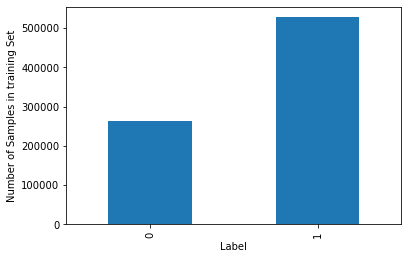

In [18]:
ax = df['rating'].value_counts(sort=False).plot(kind='bar')
ax.set_ylabel('Number of Samples in training Set')
ax.set_xlabel('Label')

In [20]:
# Dealing with imbalance in the dataset
dfn=df[df['rating']==0]
dfp=df[df['rating']==1]
df=None
dfp=dfp.iloc[:263865,:]
df=pd.concat([dfp,dfn])
df['rating'].value_counts()

0    263865
1    263865
Name: rating, dtype: int64

Text(0.5, 0, 'Label')

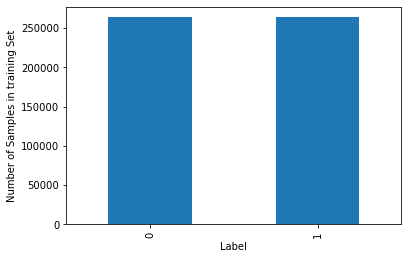

In [21]:
ax = df['rating'].value_counts(sort=False).plot(kind='bar')
ax.set_ylabel('Number of Samples in training Set')
ax.set_xlabel('Label')

In [22]:
df.to_csv('cleaned_balanced_reviews.csv',index=False)

In [23]:
def clean_reviews(review):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",review.lower()).split())

In [24]:
df['review']=df['review'].apply(clean_reviews)

In [25]:
df

,review,rating
0,purchased for my daughter and the fit is great...,1
1,love these shoes nice color very comfortable,1
2,love these shoes i can wear them all day long,1
3,good quality jeans for great price,1
4,got what i ordered and wanted thanks,1
...,...,...
791995,do not buy these frames i bought two pairs not...,0
791996,too fake must be completely without breast tis...,0
791997,came with damages,0
791998,size was too small right out of the package,0


In [26]:
stop = stopwords.words('english')
def remove_stopwords(df):
    df['review']=df['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [27]:
remove_stopwords(df)
df

,review,rating
0,purchased daughter fit great really likes,1
1,love shoes nice color comfortable,1
2,love shoes wear day long,1
3,good quality jeans great price,1
4,got ordered wanted thanks,1
...,...,...
791995,buy frames bought two pairs amazon one pair se...,0
791996,fake must completely without breast tissue wea...,0
791997,came damages,0
791998,size small right package,0


In [28]:
def lemmatization(df):
    df['review']=df['review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))    

In [29]:
lemmatization(df)
df

,review,rating
0,purchased daughter fit great really like,1
1,love shoe nice color comfortable,1
2,love shoe wear day long,1
3,good quality jean great price,1
4,got ordered wanted thanks,1
...,...,...
791995,buy frame bought two pair amazon one pair set ...,0
791996,fake must completely without breast tissue wea...,0
791997,came damage,0
791998,size small right package,0


In [30]:
def wordcloud(df,filename):
    ratings=''.join(df['review'])    
    wordcloud = WordCloud().generate(ratings)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    wordcloud.to_file('{}.png'.format(filename))

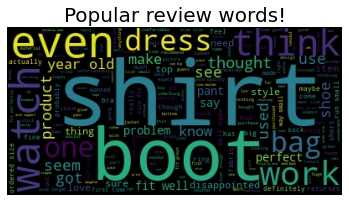

In [35]:
plt.title("Popular review words!", fontsize=20)
wordcloud(df,"wholeword.png")

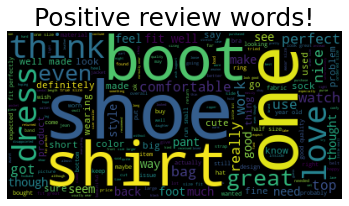

In [33]:
df_pos=df[df['rating']==1]
plt.title("Positive review words!", fontsize=25)
wordcloud(df_pos,"posword.png")

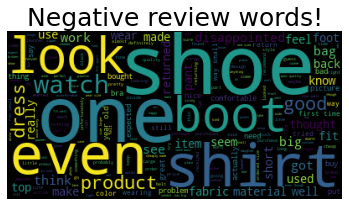

In [34]:
df_neg=df[df['rating']==0]
plt.title("Negative review words!", fontsize=25)
wordcloud(df_neg,"negword.png")

In [41]:
df.isna().sum()

review    412
rating      0
dtype: int64

In [42]:
df.dropna(subset=['review'],inplace=True)

In [43]:
df.isna().sum()

review    0
rating    0
dtype: int64

In [44]:
df.to_csv('cleaned_balanced_reviews_final.csv',index=False)